In [1]:
import os
import numpy
os.chdir("utils")
from burgers_utils import *
from mlp_network import shared_model_func
from plotting import plot_loss, list_tensor_to_list, three_plots_burgers, heat_map
import matplotlib.gridspec as gridspec

In [2]:
file_path = '../data/burgers_shock.mat'

In [3]:
# loading data from the burgers_shock.mat
# usol in the paper's script has been reffered as Exact
x, t, usol = load_data(file_path)

In [4]:
# making a spatial-temporal grid
X, T = mesh_grid(x, t)

In [5]:
# Creating test data set
# X_test is reffered as X_star
# y_test is reffered as u_star
X_test, y_test = test_data(X, T, usol)

In [6]:
# Domain bounds 
lb, ub = domain_bounds(X_test)

In [7]:
# Number of collocation points i.e. number of training points for f
N_f = 10000
# Number of initial and boudary conditions to train the model for u
N_u = 100

In [8]:
### In Physics-informed neural networks, we are predicting a latent variable u (x,t) and structure of 
### the pde f(u,x, t). variables with "u_train" in them corresponds to the training example required for u 
### and "f_train" corresponds to the training example required for f
### We don't have "y_f_train" because it's value is always zero and we specified it in the loss function

In [9]:
# In the the paper they are reffered as X_u_train, X_f_train and u_train
x_f, x_u, y_u = training_data(X, T, usol, lb, ub, N_f)

In [10]:
# From the entire initial and boundary conditions we will select N_u number of x,t,u for the training
idx = np.random.choice(x_u.shape[0], N_u, replace=False)
X_u_train = x_u[idx, :]
y_u_train = y_u[idx, :]
# Stacking collocation points and IC and BC condtions
# this will be used for imposing the structure of the Partial Differential Equation
X_f_train = np.vstack([x_f, X_u_train])

In [11]:
# Specifying the number of layers in the neural network shared between u and f
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Specifying the coefficient of viscosity
nu = 0.01/np.pi

In [12]:
# Creating a shared neural network
shared_model = shared_model_func(layers=layers, 
                                  lb=lb,
                                   ub = ub,
                                    norm = True) 
print("Shared network summary is: \n")
shared_model.summary()

Shared network summary is: 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sub (TensorFlowOpLa [(None, 2)]          0           

In [13]:
# Specified in the paper
loss_function = tf.keras.losses.MeanSquaredError()
# Working perfect 
# 1. choose_optimizer(lr=5e-02, ds=100, er=0.96, opt='Adam')
# 2. choose_optimizer(lr=1e-02, ds=100, er=0.96, opt='RMSprop')
optimizer = choose_optimizer(lr=1e-02, ds=100, er=0.955, opt='Adam', lear_rate_sched=True)
train_dataset = data_gen(X_f_train, batch_size=X_f_train.shape[0])
max_Iter = 10000
loss_u = []
loss_f = []
loss_model = []
for epoch in tqdm(range(max_Iter)):
    for (X_f_train, t_f_train) in train_dataset:   
        # Passing the entire data in a single batch (That's how they did in the original paper)
        loss_1, loss_2, loss_combine = model_build_compile(x_f=X_f_train, t_f=t_f_train, 
                                                           x_u = X_u_train[:,0:1], t_u = X_u_train[:,1:2],
                                                           u = y_u_train, shared_model=shared_model, 
                                                           loss_function=loss_function,
                                                           optimizer=optimizer)
        loss_u.append(loss_1)
        loss_f.append(loss_2)
        loss_model.append(loss_combine)
        
        if ((epoch+1)%1000 == 0):
            print("After {0} epochs loss on variable u is {1}".format(epoch+1, loss_1.numpy()))
            print("After {0} epochs loss on PDE structure (f) is {1}".format(epoch+1, loss_2.numpy()))
            print("After {0} epochs combined loss is {1}".format(epoch+1, loss_combine.numpy()))
            
        

  0%|          | 0/10000 [00:00<?, ?it/s]

 10%|█         | 1006/10000 [00:24<03:26, 43.61it/s]

After 1000 epochs loss on variable u is 0.004003128502517939
After 1000 epochs loss on PDE structure (f) is 0.007501587737351656
After 1000 epochs combined loss is 0.011504716239869595


 20%|██        | 2006/10000 [00:47<03:01, 43.92it/s]

After 2000 epochs loss on variable u is 0.00023109852918423712
After 2000 epochs loss on PDE structure (f) is 0.0005230014212429523
After 2000 epochs combined loss is 0.0007540999504271895


 30%|███       | 3006/10000 [01:09<02:39, 43.76it/s]

After 3000 epochs loss on variable u is 7.233413634821773e-05
After 3000 epochs loss on PDE structure (f) is 0.00027917561237700284
After 3000 epochs combined loss is 0.00035150974872522056


 40%|████      | 4006/10000 [01:31<02:17, 43.71it/s]

After 4000 epochs loss on variable u is 3.888412902597338e-05
After 4000 epochs loss on PDE structure (f) is 0.00025490563712082803
After 4000 epochs combined loss is 0.0002937897661468014


 50%|█████     | 5006/10000 [01:54<01:53, 43.84it/s]

After 5000 epochs loss on variable u is 2.4271063011838123e-05
After 5000 epochs loss on PDE structure (f) is 0.00012082201283192262
After 5000 epochs combined loss is 0.00014509307584376074


 60%|██████    | 6006/10000 [02:16<01:31, 43.88it/s]

After 6000 epochs loss on variable u is 1.6929046978475526e-05
After 6000 epochs loss on PDE structure (f) is 6.002670488669537e-05
After 6000 epochs combined loss is 7.69557518651709e-05


 70%|███████   | 7006/10000 [02:38<01:08, 43.89it/s]

After 7000 epochs loss on variable u is 1.3040767953498289e-05
After 7000 epochs loss on PDE structure (f) is 5.077007881482132e-05
After 7000 epochs combined loss is 6.381084676831961e-05


 80%|████████  | 8006/10000 [03:01<00:45, 43.77it/s]

After 8000 epochs loss on variable u is 1.047488967742538e-05
After 8000 epochs loss on PDE structure (f) is 4.427303065313026e-05
After 8000 epochs combined loss is 5.4747920330555644e-05


 90%|█████████ | 9006/10000 [03:23<00:22, 43.95it/s]

After 9000 epochs loss on variable u is 8.547875040676445e-06
After 9000 epochs loss on PDE structure (f) is 3.943243427784182e-05
After 9000 epochs combined loss is 4.7980309318518266e-05


100%|██████████| 10000/10000 [03:45<00:00, 44.34it/s]

After 10000 epochs loss on variable u is 7.099542926880531e-06
After 10000 epochs loss on PDE structure (f) is 3.5544402635423467e-05
After 10000 epochs combined loss is 4.2643945562304e-05


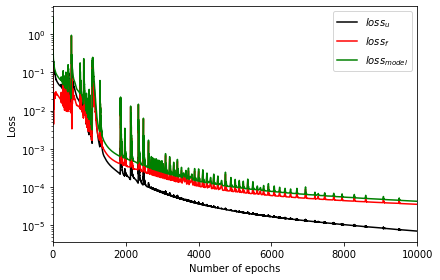

In [14]:
loss_list = [loss_u, loss_f, loss_model]
plot_loss(num_epoch=max_Iter, y_list=loss_list, which='burgers')

In [15]:
y_hat = predict(shared_model, X_test)

In [16]:
loss = error_loss(y_test, y_hat)
print("*****************************************************\n")
print("Error for the latent variable u is: {:e}".format(loss))
print("\n*****************************************************")

*****************************************************

Error for the latent variable u is: 1.423349e-02

*****************************************************


<Figure size 432x288 with 0 Axes>

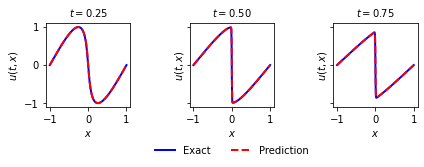

In [17]:
U_pred = griddata(X_test, y_hat.flatten(), (X, T), method='cubic')
three_plots_burgers(x, usol, U_pred)

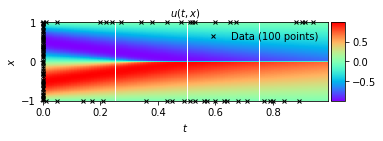

In [18]:
#Predicted solution on spatio-temporal grid
heat_map(U_pred, t, x, X_u_train, 'solution_heatmap')

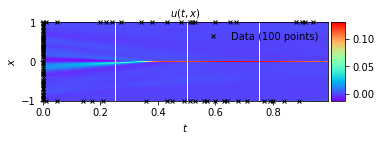

In [19]:
# Error of the solution on spatio-temporal grid
U_true  = griddata(X_test, y_test.flatten(), (X, T), method='cubic')
Error = U_pred - U_true
heat_map(Error, t, x, X_u_train, 'error_heatmap')

In [20]:
# Saves the model to Tensorflow SavedModel or a single HDF5 file.
shared_model.save(filepath='../models/Burgers/Burgers_shared_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/Burgers/Burgers_shared_model/assets


In [21]:
# save the weights
shared_model.save_weights('../models/Burgers/weights')